In [1]:
#Import packages
import numpy as np
from keras.layers import *
from keras.models import *
from keras.datasets import mnist
from keras.optimizers import RMSprop
import keras.backend as K
import matplotlib.pyplot as plt
from functools import partial

Using TensorFlow backend.


In [2]:
import tensorflow as tf

In [3]:
#Hyperparameters
batch_size = 32
iterations = 10000

#Loss tracking
d_loss = []
g_loss = []
gp_loss = []

N = 32

def generate_rect(x, y, w, h):
  data = np.zeros((N,N))
  data[x:x+w+1, y:y+h+1] = 1
  data[x+1:x+w, y+1:y+h] = 0
  #data = np.reshape(data, (N*N))
  return data
'''FILLED RECTANGLES'''

def create_filled_rectangle(posX, posY, width, height):
    data = np.zeros((N, N))
    data[posX : posX + width + 1, posY : posY + height + 1] = 1
    return data

def create_thick_rectangles(posX, posY, width, height, thickness_x, thickness_y):
    empyt_rect_width = width - 2*thickness_x
    empyt_rect_height = height - 2*thickness_y
        
    data = np.zeros((N,N))
    data[x:x+w+1, y:y+h+1] = 1
    
    if empyt_rect_width > 0 and empyt_rect_height > 0:
        data[x+thickness_x: x+thickness_x+empyt_rect_width+1, y+thickness_y: y+thickness_y+empyt_rect_height+1] = 0
    else:
        return None

    return data

x_train = []

for x in range(0, N-2):
    for y in range(0, N-2):
        for w in range(2,N):
            for h in range(2,N):
                if x+w<N and y+h<N:
                    #x_train.append(generate_rect(x,y,w,h))
                    #x_train.append(create_filled_rectangle(x,y,w,h))
                    data = create_thick_rectangles(x,y,w,h, 2, 2)
                    if data is not None:
                        x_train.append(data)

x_train = np.array(x_train).astype('int16')
x_train = np.reshape(x_train, (np.shape(x_train)[0], 32, 32, 1))
print(np.shape(x_train))

(142884, 32, 32, 1)


In [4]:
def AdaIN(x):
    #Normalize x[0]
    mean = K.mean(x[0], axis = [0, 1], keepdims = True)
    std = K.std(x[0], axis = [0, 1], keepdims = True) + 1e-7
    y = (x[0] - mean) / std
    
    #Reshape gamma and beta
    pool_shape = [-1, 1, 1, y.shape[-1]]
    g = K.reshape(x[1], pool_shape)
    b = K.reshape(x[2], pool_shape)
    
    #Multiply by x[1] (GAMMA) and add x[2] (BETA)
    return y * g + b

In [5]:
def gradient_penalty_loss(y_true, y_pred, sample, weight):
    gradients = K.gradients(y_pred, sample)[0]
    gradients_sqr = K.square(gradients)
    gradient_penalty = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))

    # (weight / 2) * ||grad||^2
    # Penalize the gradient norm
    return K.mean(gradient_penalty) * (weight / 2)

In [6]:
#Build Generator network.

#Latent input
#latent = Input([100])
latent = Input([32])

#Mapping
w = Dense(256, activation = 'relu')(latent)
w = Dense(256, activation = 'relu')(w)

#Small image
x = Dense(4*4*128, activation = 'relu')(w)
x = Reshape([4, 4, 128])(x)

#Layer = Convolution, AdaIN, Activation
#4x4x128
gamma = Dense(64, bias_initializer = 'ones')(w)
beta = Dense(64)(w)

x = Conv2D(64, 4, padding = 'same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

#8x8x64
gamma = Dense(32, bias_initializer = 'ones')(w)
beta = Dense(32)(w)

x = Conv2D(32, 4, padding = 'same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

#16x16x32
gamma = Dense(16, bias_initializer = 'ones')(w)
beta = Dense(16)(w)

x = Conv2D(16, 4, padding = 'same')(x)
x = Lambda(AdaIN)([x, gamma, beta])
x = Activation('relu')(x)
x = UpSampling2D()(x)

# 32x32x16
x = Conv2D(8, 4, padding = 'same', activation = 'relu')(x)
x = Dense(1, activation = 'sigmoid')(x)

generator = Model(inputs = latent, outputs = x)
generator.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          8448        input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2048)         526336      dense_2[0][0]                    
__________________________________________________________________________________________________
reshap

In [7]:
#Build discriminator network.
discriminator = Sequential()

#Discriminator starts with an image of shape 32x32x1.
#Use convolution and pooling to extract features and make the image smaller.
discriminator.add(Conv2D(filters = 16, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = [32, 32, 1]))
discriminator.add(AveragePooling2D())

#Now the image is 16x16x16. Use more convolution and pooling.
discriminator.add(Conv2D(filters = 32, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = [16, 16, 1]))
discriminator.add(AveragePooling2D())

#Now the image is 8x8x32. Use more convolution and pooling.
discriminator.add(Conv2D(filters = 64, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = [8, 8, 1]))
discriminator.add(AveragePooling2D())

#Now the image is 4x4x64. Use more convolution and flatten the image.
discriminator.add(Conv2D(filters = 128, kernel_size = 4, padding = 'same', activation = 'relu'))
discriminator.add(Flatten())

#Now you have a vector of length 4*4*128, use fully connected networks to find your output
discriminator.add(Dense(100, activation = 'relu'))
#discriminator.add(Dense(8, activation = 'relu'))
discriminator.add(Dense(1)) 

In [8]:
#Build network to train the discriminator.
#Discriminator will train, but Generator won't train.
for layer in discriminator.layers:
    layer.trainable = True
    
for layer in generator.layers:
    layer.trainable = False
    
#Get real image
real_image = Input([32, 32, 1])
#Discriminator classifies
validity_real = discriminator(real_image)


#Get latent input
#latent_input = Input([100])
latent_input = Input([32])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity_fake = discriminator(fake_image)

#Create and compile the model
DiscriminatorModel = Model(inputs = [real_image, latent_input], outputs = [validity_real, validity_fake, validity_real])

gp_loss_partial = partial(gradient_penalty_loss, sample = real_image, weight = 10)

DiscriminatorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = ['mean_squared_error', 'mean_squared_error', gp_loss_partial])

DiscriminatorModel.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 1)    832353      input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            377529      input_2[0][0]                    
                                                                 model_1[1][0]                    
Total par

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\topology.py:1541: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'sequential_1/dense_12/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'sequential_1_1/dense_12/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'sequential_1/dense_12/BiasAdd:0' shape=(?, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [9]:
#Build network to train the generator.
#Discriminator won't train, but Generator will train.
for layer in discriminator.layers:
    layer.trainable = False
    
for layer in generator.layers:
    layer.trainable = True

#Get latent input
#latent_input = Input([100])
latent_input = Input([32])

#Generate an image
fake_image = generator(latent_input)

#Discriminator classifies
validity = discriminator(fake_image)

#Create and compile the model
GeneratorModel = Model(inputs = latent_input, outputs = validity)

GeneratorModel.compile(optimizer = RMSprop(lr = 0.0002), loss = 'mean_squared_error')

In [10]:
#Train the models in a loop
for i in range(iterations):
    
    print('\rIteration ' + str(i), end = '\r')
    
    #Get labels
    real_labels = np.ones([batch_size, 1])
    fake_labels = np.zeros([batch_size, 1])
    
    #Get images and latent vectors
    image_indices = np.random.randint(0, x_train.shape[0] - 1, [batch_size])
    real_images = x_train[image_indices]
    #latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 32])
    #latent_vectors = np.random.randint(2,[batch_size, 8])
    
    #Train D
    loss = DiscriminatorModel.train_on_batch([real_images, latent_vectors], [real_labels, fake_labels, real_labels])
    d_loss.append(loss[1]/2 + loss[2]/2)
    gp_loss.append(loss[3])
    
    #Get latent vectors
    #latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 100])
    latent_vectors = np.random.normal(0.0, 1.0, [batch_size, 32])
    
    #Train G
    loss = GeneratorModel.train_on_batch(latent_vectors, real_labels)
    g_loss.append(loss)

C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\User\anaconda3\envs\gputest\lib\site-packages\keras\engine\training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


C:\Users\User\anaconda3\envs\gputest\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


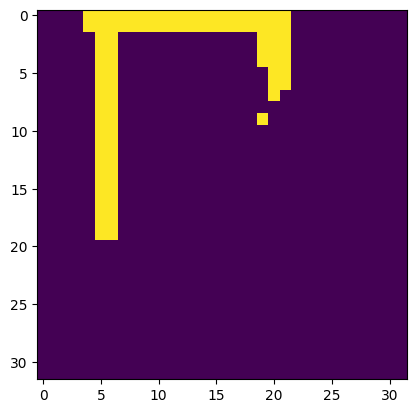

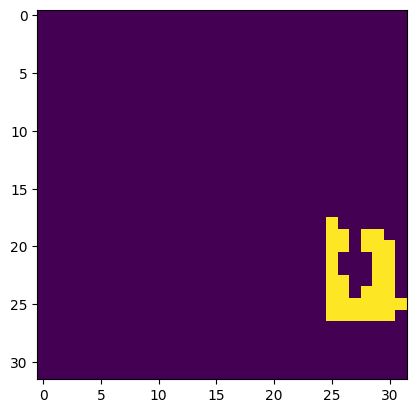

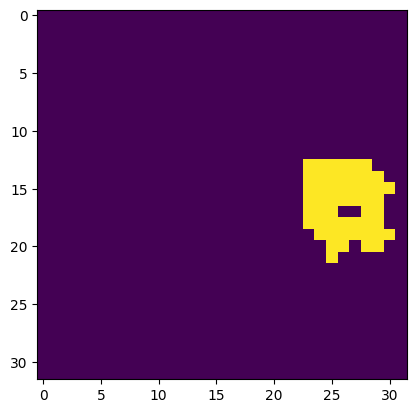

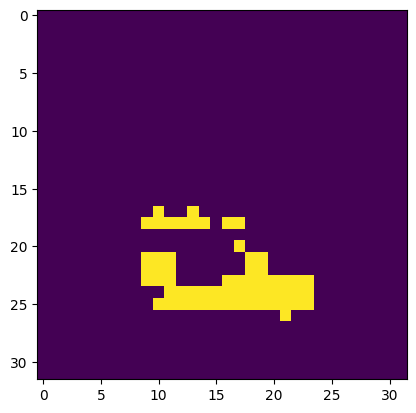

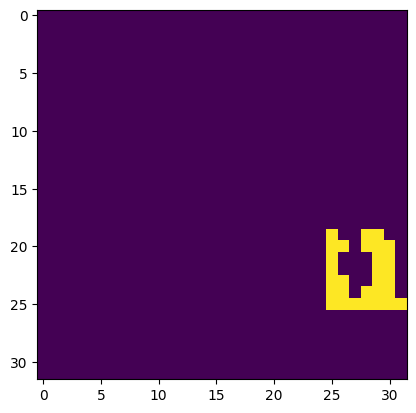

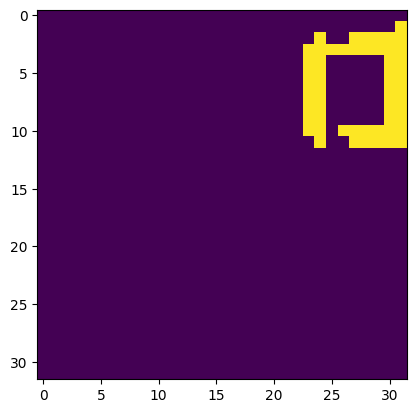

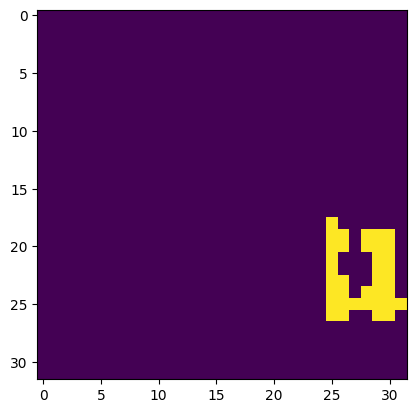

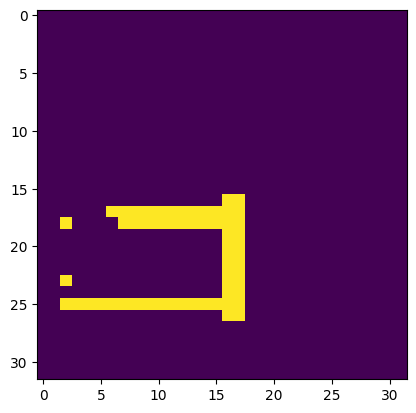

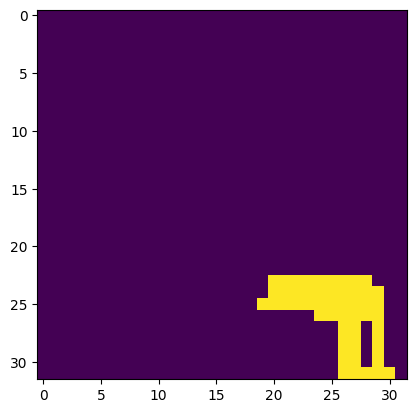

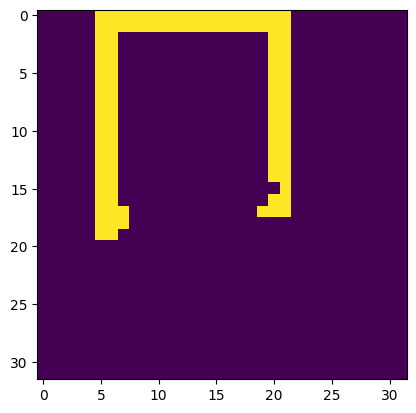

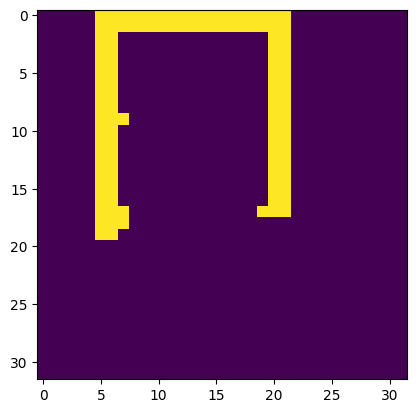

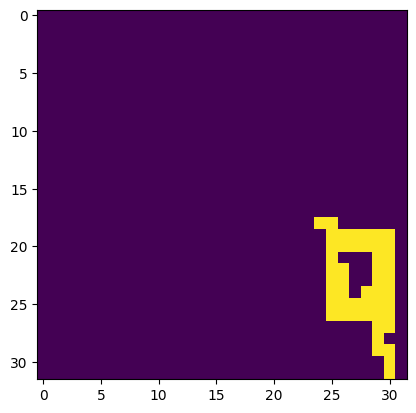

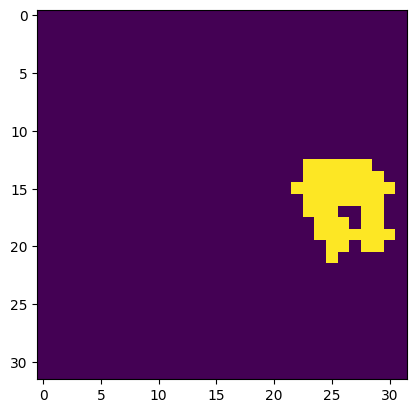

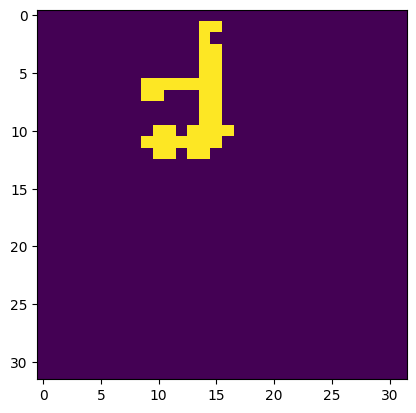

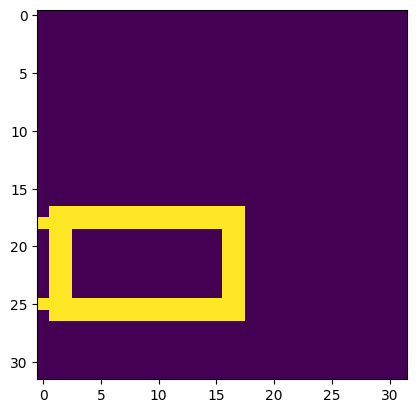

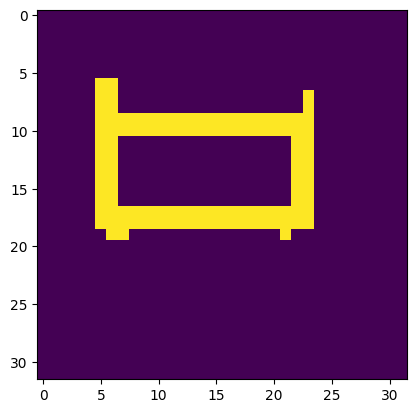

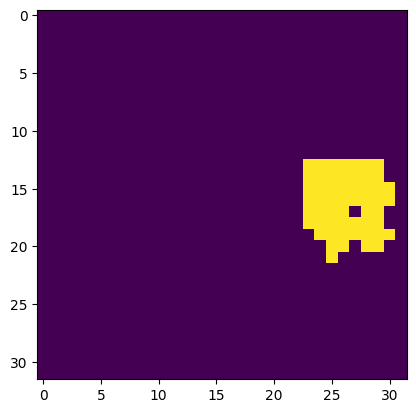

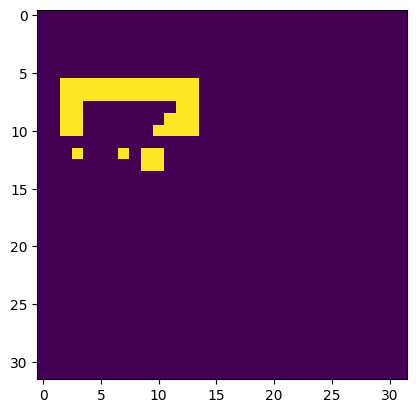

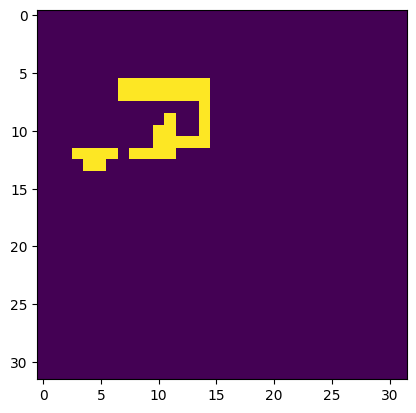

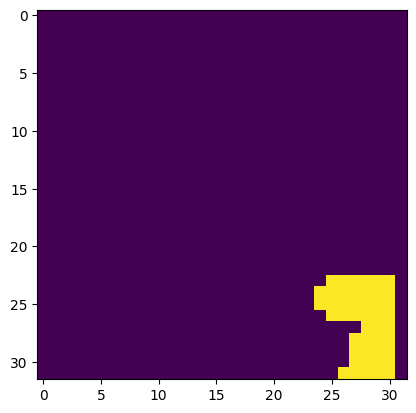

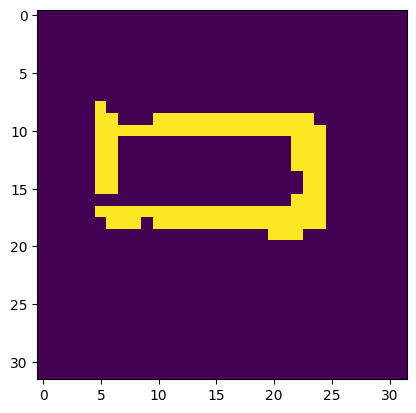

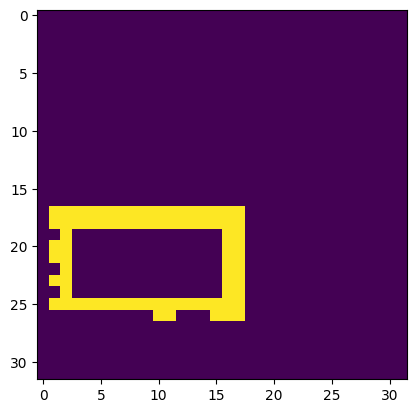

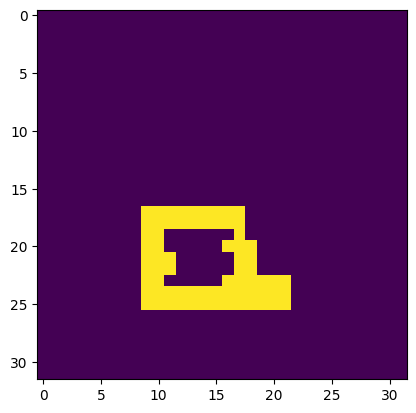

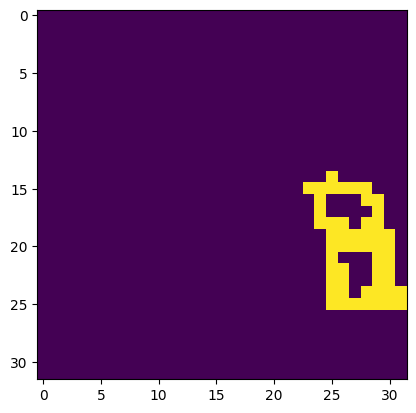

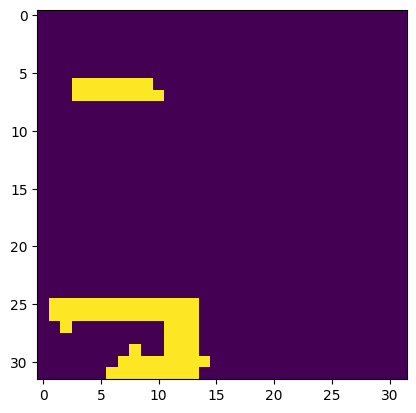

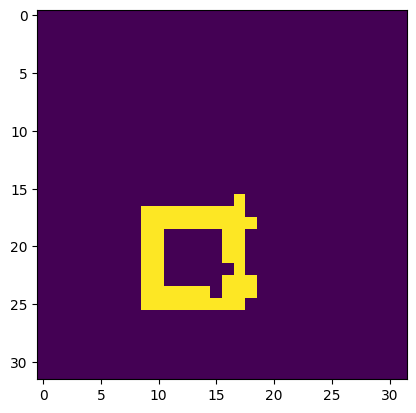

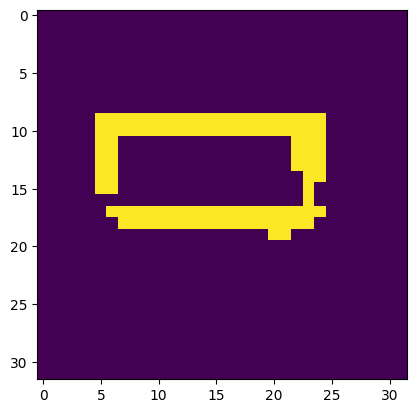

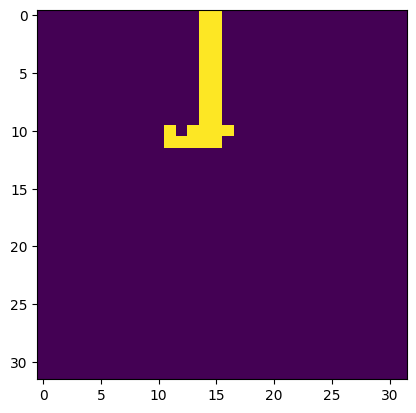

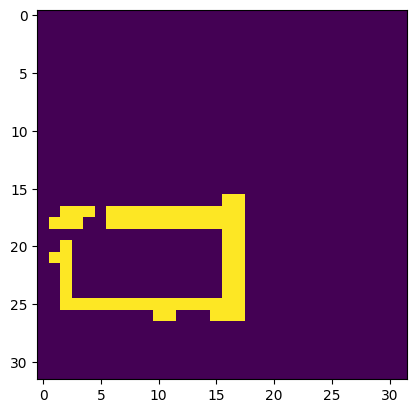

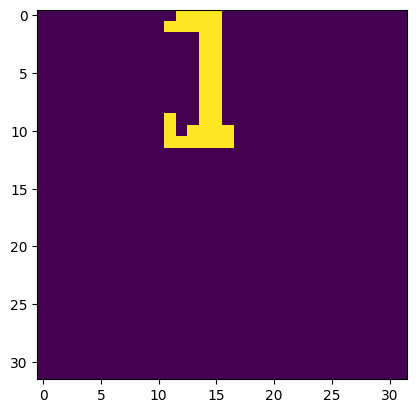

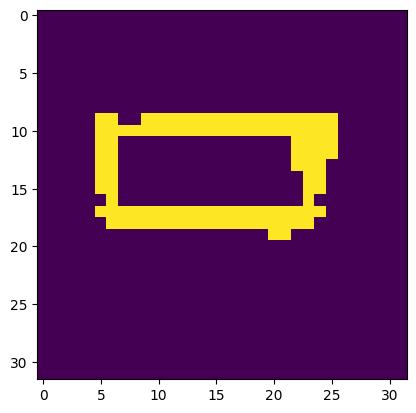

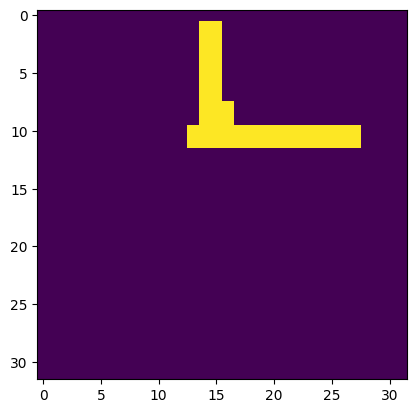

In [12]:
#Show samples
#latent_vectors = np.random.normal(0.0, 1.0, [8, 100])
latent_vectors = np.random.normal(0.0, 1.0, [32, 32])
fake_images = generator.predict(latent_vectors)
fake_images = np.rint(fake_images)

for i in range(32):
    plt.figure(i)
    plt.imshow(fake_images[i])
plt.show()